In [1]:
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly import subplots
import mlxtend as mlx
import numpy as np
import pandas as pd
import statsmodels
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.stats import descriptivestats
from IPython.display import display, HTML, Image
import plotly.io as pio
import plotly.express as px
import json
from urllib.request import urlopen
from collections import Counter
import string
import re
import scipy
import scipy.cluster
import pandas as pd

pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_columns = 50
pio.templates.default = "plotly_dark"

# Convert scientific notation to plain numbers
pd.options.display.float_format = '{:.2f}'.format

def display_side_by_side(*args):
    html_str = '<div style="display: flex; justify-content: flex-start;">'
    for df in args:
        if isinstance(df, pd.Series):
            df = df.to_frame()
        html_str += f'<div style="flex: 1; padding: 0;">{df.to_html(index=True)}</div>'
    html_str += '</div>'
    
    display(HTML(html_str))

In [2]:
#Read the parquet file that we generated on the category clustering notebook
df = pd.read_parquet('Sales with Stock Categories.parquet')
display_side_by_side(df.head())
display_side_by_side(df.tail())

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceDay,InvoiceHour,CustomerID_str,Label,Category
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom,15.30,2010-12-01,8,17850,3.00,Misc - Other
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34,2010-12-01,8,17850,6.00,Bases and Holders
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom,22.00,2010-12-01,8,17850,3.00,Misc - Other
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34,2010-12-01,8,17850,3.00,Misc - Other
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom,20.34,2010-12-01,8,17850,3.00,Misc - Other


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceDay,InvoiceHour,CustomerID_str,Label,Category
527752,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.00,France,10.20,2011-12-09,12,12680,10.00,Misc - Designed
527753,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.00,France,12.60,2011-12-09,12,12680,10.00,Misc - Designed
527754,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.00,France,16.60,2011-12-09,12,12680,10.00,Misc - Designed
527755,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.00,France,16.60,2011-12-09,12,12680,10.00,Misc - Designed
527756,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.00,France,14.85,2011-12-09,12,12680,10.00,Misc - Designed


In [3]:
#We will focus here on identifying customer segments to see what insights can be gained with respect to average item purchase quantity, average order totals, and purchase frequency
#First let's get the subset of data that we need
customers_df = df[['InvoiceNo', 'StockCode', 'Quantity', 'TotalPrice', 'InvoiceDay', 'CustomerID_str', 'Category']]
customers_with_id = customers_df[~(customers_df['CustomerID_str'] =='nan')]
customers_with_id

#Initialize some date variables to be used later
df_last_date = df.iat[-1, 9]
df_first_date = df.iat[0, 9]
df_date_delta = df_last_date - df_first_date

In [4]:
#Group the dataframe that is to be analyzed with the information that we plan on clustering
customers_with_id_filtered = customers_with_id[['Quantity', 'TotalPrice','CustomerID_str', 'InvoiceNo','InvoiceDay', 'StockCode']].groupby(['CustomerID_str', 'InvoiceNo','InvoiceDay', 'StockCode']).sum()
customers_with_id_filtered
customer_with_id_reset = customers_with_id_filtered.reset_index(level=['InvoiceNo', 'InvoiceDay', 'StockCode'])
customer_with_id_reset

#Initialize a dictionary that will be used to store calculations on customer transaction statistics
customer_stats_dict = {}
customer_list = list(set(customer_with_id_reset.index))
customer_reindexed = customer_with_id_reset.reset_index()

In [5]:
#Gather data on each customer by iteration, store calculations on totals, averages, ordering tendencies and recency.
for customer in customer_list:
    cust_df = customer_reindexed[customer_reindexed['CustomerID_str'] == customer]
    num_orders = len(np.unique(cust_df['InvoiceNo']))
    num_order_days =  len(np.unique(cust_df['InvoiceDay']))
   
    days_since_last = df_last_date - cust_df.iat[-1, 2]
    days_since_last_num = days_since_last.days
    days_since_first = df_last_date - cust_df.iat[0, 2]
    days_since_first_num = days_since_first.days
        
    total_quantity = np.sum(cust_df['Quantity'])
    total_purchases = np.sum(cust_df['TotalPrice'])

    average_quantity = total_quantity/num_orders
    average_total = total_purchases /num_orders

    unique_orders = cust_df['InvoiceNo'].unique()
    unique_items_purchased = []

    for order in unique_orders:
        transactions_df = cust_df[cust_df['InvoiceNo'] == order]
        unique_items_purchased.append(len(np.unique(transactions_df['StockCode'])))

    total_unique_stock_purchased = len(np.unique(cust_df['StockCode']))
    total_unique_stock_per_order = np.sum(unique_items_purchased)
    average_unique_stock_per_order = total_unique_stock_per_order/num_orders

    customer_stats_dict[customer] = [num_orders, num_order_days, days_since_last_num, average_unique_stock_per_order, average_quantity, average_total, total_unique_stock_purchased, total_quantity,total_purchases]


In [6]:
#Create a dataframe out of the dictionary from the previous cell
customer_stats = pd.DataFrame(customer_stats_dict)
customer_stats_df = customer_stats.T
customer_stats_df.columns = ['num_orders', 'num_order_days', 'days_since_last', 'ave_stock_per_order', 'ave_qty', 'ave_purchased', 'total_unique_stock', 'total_qty', 'total_purchases']
customer_stats_df

,num_orders,num_order_days,days_since_last,ave_stock_per_order,ave_qty,ave_purchased,total_unique_stock,total_qty,total_purchases
14754,2.00,2.00,44.00,20.50,243.00,319.03,38.00,486.00,638.05
13777,33.00,24.00,0.00,5.97,390.82,787.19,36.00,12897.00,25977.16
16529,1.00,1.00,190.00,30.00,198.00,455.25,30.00,198.00,455.25
17389,34.00,32.00,0.00,6.26,223.88,936.28,45.00,7612.00,31833.68
13283,2.00,2.00,59.00,3.50,45.00,46.83,7.00,90.00,93.66
...,...,...,...,...,...,...,...,...,...
13089,97.00,66.00,2.00,18.68,320.31,606.45,636.00,31070.00,58825.83
13634,5.00,5.00,33.00,36.80,140.80,315.03,156.00,704.00,1575.16
15806,3.00,3.00,46.00,10.33,200.67,261.53,24.00,602.00,784.58
14733,12.00,12.00,16.00,16.83,313.67,798.83,102.00,3764.00,9585.91


In [7]:
#Create a custom metric that tries to capture customer activity by dividing each customer's total number of orders by how recent their last order was, making sure both columns are on the same scale first which should help give equal weight to both values  
customer_activity = customer_stats_df[['num_orders', 'days_since_last']]
mm_scaler = MinMaxScaler(feature_range=(1,100)).set_output(transform='pandas')
customer_activity_scaled = mm_scaler.fit_transform(customer_activity)
customer_activity_scaled['customer_activity_score'] = customer_activity_scaled['num_orders']/customer_activity_scaled['days_since_last']

#Add this new column to the main df
score_dict = customer_activity_scaled['customer_activity_score'].to_dict()
customer_stats_df['customer_activity_score'] = customer_stats_df.index.map(score_dict)
customer_stats_df

,num_orders,num_order_days,days_since_last,ave_stock_per_order,ave_qty,ave_purchased,total_unique_stock,total_qty,total_purchases,customer_activity_score
14754,2.00,2.00,44.00,20.50,243.00,319.03,38.00,486.00,638.05,0.12
13777,33.00,24.00,0.00,5.97,390.82,787.19,36.00,12897.00,25977.16,16.45
16529,1.00,1.00,190.00,30.00,198.00,455.25,30.00,198.00,455.25,0.02
17389,34.00,32.00,0.00,6.26,223.88,936.28,45.00,7612.00,31833.68,16.94
13283,2.00,2.00,59.00,3.50,45.00,46.83,7.00,90.00,93.66,0.09
...,...,...,...,...,...,...,...,...,...,...
13089,97.00,66.00,2.00,18.68,320.31,606.45,636.00,31070.00,58825.83,30.94
13634,5.00,5.00,33.00,36.80,140.80,315.03,156.00,704.00,1575.16,0.30
15806,3.00,3.00,46.00,10.33,200.67,261.53,24.00,602.00,784.58,0.15
14733,12.00,12.00,16.00,16.83,313.67,798.83,102.00,3764.00,9585.91,1.20


In [8]:
from statsmodels.stats import descriptivestats
#Get an overview of the numerical columns we plan on using as features for our clusters
stats_df = descriptivestats.describe(customer_stats_df[['customer_activity_score', 'total_unique_stock', 'total_qty', 'total_purchases']])
display_side_by_side(stats_df[:15].round(2), stats_df[15:].round(2))

,customer_activity_score,total_unique_stock,total_qty,total_purchases
nobs,4334.00,4334.00,4334.00,4334.00
missing,0.00,0.00,0.00,0.00
mean,0.69,61.43,1189.98,2021.47
std_err,0.04,1.30,76.60,135.30
upper_ci,0.77,63.97,1340.11,2286.67
lower_ci,0.61,58.89,1039.84,1756.28
std,2.82,85.31,5042.96,8907.50
iqr,0.41,61.00,831.75,1326.06
iqr_normal,0.30,45.22,616.58,983.01
mad,0.89,50.10,1306.40,2204.75


In [9]:
#Let's create some boxplots to see how our values are distributed
fig = subplots.make_subplots(rows=2, cols=2, vertical_spacing=0.2)

hist1 = go.Box(x=customer_stats_df['customer_activity_score'], name='customer_activity_score')
hist2 = go.Box(x=customer_stats_df['total_unique_stock'], name ='total_unique_stock')
hist3 = go.Box(x=customer_stats_df['total_qty'], name='total_qty')
hist4 = go.Box(x=customer_stats_df['total_purchases'], name='total_purchases')

fig.append_trace(hist1, 1,1)
fig.append_trace(hist2, 1,2)
fig.append_trace(hist3, 2,1)
fig.append_trace(hist4, 2,2)

fig.update_layout(title = 'Boxplots for Numerical Columns', title_x = 0.5, width=1600)

fig.show()

In [10]:
#We can definitely see the presence of extreme outliers from the graphs above so we will filter them out
customer_stats_no_outliers = customer_stats_df[(customer_stats_df['customer_activity_score'] < 60) & (customer_stats_df['total_unique_stock'] < 1000) & (customer_stats_df['total_qty'] < 100000) & (customer_stats_df['total_purchases'] < 200000)]
customer_stats_no_outliers.sort_values(by='customer_activity_score', ascending=False)

,num_orders,num_order_days,days_since_last,ave_stock_per_order,ave_qty,ave_purchased,total_unique_stock,total_qty,total_purchases,customer_activity_score
15311,91.00,90.00,0.00,25.90,419.71,667.78,567.00,38194.00,60767.90,44.46
14606,90.00,88.00,1.00,29.52,69.04,133.41,816.00,6214.00,12006.65,34.76
13089,97.00,66.00,2.00,18.68,320.31,606.45,636.00,31070.00,58825.83,30.94
13408,62.00,41.00,1.00,7.71,261.81,453.50,234.00,16232.00,28117.04,24.07
12971,86.00,71.00,3.00,3.55,108.01,130.12,94.00,9289.00,11189.91,23.41
...,...,...,...,...,...,...,...,...,...,...
18011,1.00,1.00,373.00,28.00,71.00,102.79,28.00,71.00,102.79,0.01
16583,1.00,1.00,373.00,14.00,111.00,233.45,14.00,111.00,233.45,0.01
12791,1.00,1.00,373.00,1.00,96.00,177.60,1.00,96.00,177.60,0.01
13065,1.00,1.00,373.00,14.00,74.00,205.86,14.00,74.00,205.86,0.01


In [12]:
#Create a 3D Scatter Plot of the three main metrics we plan to use as features in clustering customers, with outliers removed
px.scatter_3d(data_frame=customer_stats_no_outliers, x='customer_activity_score', y='total_unique_stock', z='total_purchases', title='3D Scatterplot of Customer Metrics with Outliers Removed', height=750)

In [13]:
#Create histograms to show the distribution of each column after removing outliers above
fig = subplots.make_subplots(rows=3, cols=1, vertical_spacing=0.1)

hist1 = go.Histogram(x=customer_stats_no_outliers['customer_activity_score'], texttemplate='%{y}')  
                    # xbins=dict(start=0, end = float(top_percentile['UnitPrice']), size=1), name='Item Price')
hist2 = go.Histogram(x=customer_stats_no_outliers['total_unique_stock'], texttemplate='%{y}')
                    # xbins=dict(size=100), name='Customer ID Counts')
hist3 = go.Histogram(x=customer_stats_no_outliers['total_purchases'],  texttemplate='%{y}')
                      #xbins=dict(start=0, end = float(top_percentile['TotalPrice']), size=10), name='Total Row Price')

# Update x-axis labels
fig.update_xaxes(title_text='Number of Orders', row=1, col=1)
fig.update_xaxes(title_text='Average Stock Ordered Per Day Ordered', row=2, col=1)
fig.update_xaxes(title_text=f'Average Purchased per Transaction', row=3, col=1)

fig.append_trace(hist1, 1,1)
fig.append_trace(hist2, 2,1)
fig.append_trace(hist3, 3,1)

fig.update_layout(title = 'Counts for each Numerical Column', title_x = 0.5, width =1400, height = 750)
fig.show()

In [14]:
import scipy.stats as stats
from pingouin import multivariate_normality

#Let's run some tests
stat, p_value = stats.bartlett(customer_stats_no_outliers['customer_activity_score'], customer_stats_no_outliers['total_unique_stock'], customer_stats_no_outliers['total_purchases'])
print(stat, p_value)


result = multivariate_normality(customer_stats_no_outliers[['customer_activity_score', 'total_unique_stock', 'total_purchases']], alpha=0.05)
print(result)

95012.30508112704 0.0
HZResults(hz=1185.684004748816, pval=0.0, normal=False)


In [ ]:
#The results from the Bartlett test (high test statistic) indicate that the variances among our data are not equal while the result for the second test of multivariate normality outputting normal = False means exactly just that.

from sklearn.preprocessing import QuantileTransformer
#In order to address the results of our tests above and help improve our model's ability to cluster, we will use Quantile Transformer to scale and standardize our data as it can force distributions to be normal - which will help align our data to the assumptions needed for using Gaussian Mixture

scaler = QuantileTransformer(n_quantiles=1000, output_distribution='normal').set_output(transform="pandas")
customer_stats_scaled = scaler.fit_transform(customer_stats_no_outliers[['customer_activity_score', 'total_unique_stock', 'total_purchases']])
customer_stats_scaled

,customer_activity_score,total_unique_stock,total_purchases
14754,-0.01,0.06,-0.04
13777,2.87,0.02,2.46
16529,-1.06,-0.13,-0.30
17389,2.89,0.20,2.55
13283,-0.16,-1.27,-1.85
...,...,...,...
13089,3.22,3.11,2.81
13634,0.49,1.39,0.65
15806,0.12,-0.33,0.14
14733,1.20,0.95,2.00


In [16]:
#Let's see the effects of applying a Quantile Transform on the distribution of our data
fig = subplots.make_subplots(rows=3, cols=1, vertical_spacing=0.1)

hist1 = go.Histogram(x=customer_stats_scaled['customer_activity_score'], texttemplate='%{y}')  
                    # xbins=dict(start=0, end = float(top_percentile['UnitPrice']), size=1), name='Item Price')
hist2 = go.Histogram(x=customer_stats_scaled['total_unique_stock'], texttemplate='%{y}')
                    # xbins=dict(size=100), name='Customer ID Counts')
hist3 = go.Histogram(x=customer_stats_scaled['total_purchases'],  texttemplate='%{y}')
                      #xbins=dict(start=0, end = float(top_percentile['TotalPrice']), size=10), name='Total Row Price')

# Update x-axis labels
fig.update_xaxes(title_text=  'Order Frequency', row=1, col=1)
fig.update_xaxes(title_text='Average Quantity Per Order', row=2, col=1)
fig.update_xaxes(title_text='Average Purchased per Transaction', row=3, col=1)

fig.append_trace(hist1, 1,1)
fig.append_trace(hist2, 2,1)
fig.append_trace(hist3, 3,1)

fig.update_layout(title = 'Counts for each Numerical Column', title_x = 0.5, width =1400, height = 750)
fig.show()

In [17]:
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import chi2

X_check = customer_stats_scaled

#We will run a likelihood ratio test in order to determine if the use of Gaussian Mixture and its multiple components can be justified over a simpler, single component model.

# First fit the two different models, and then test the log-likelihood of each
test_model1 = GaussianMixture(n_components=1, random_state=42).fit(X_check)
test_model2 = GaussianMixture(n_components=2, random_state=42).fit(X_check)
log_likelihood1 = test_model1.score(X_check) * X_check.shape[0]
log_likelihood2 = test_model2.score(X_check) * X_check.shape[0]

# Calculate the Likelihood Ratio statistic based on its formula
LR_statistic = -2 * (log_likelihood1 - log_likelihood2)

# Calculate the degrees of freedom and use this value on a chi-squared test
n_features = X_check.shape[1]
n_params1 = 1 * n_features + 1 * (n_features * (n_features + 1) / 2) + (1 - 1)
n_params2 = 2 * n_features + 2 * (n_features * (n_features + 1) / 2) + (2 - 1)
deg_freedom = n_params2 - n_params1
chi_p = chi2.sf(LR_statistic, deg_freedom)

print(f"Likelihood Ratio Statistic: {LR_statistic}")
print(f"p-value: {chi_p:.4f}")
#Given that magnitude of the Likelihood Ratio Statistic, which suggests that more components provide a better fit and our p-value which is miniscule, these two allows us to reject our null hypothesis that a simpler model would perform the similarly to a more complex model.

Likelihood Ratio Statistic: 2687.9680554993793
p-value: 0.0000


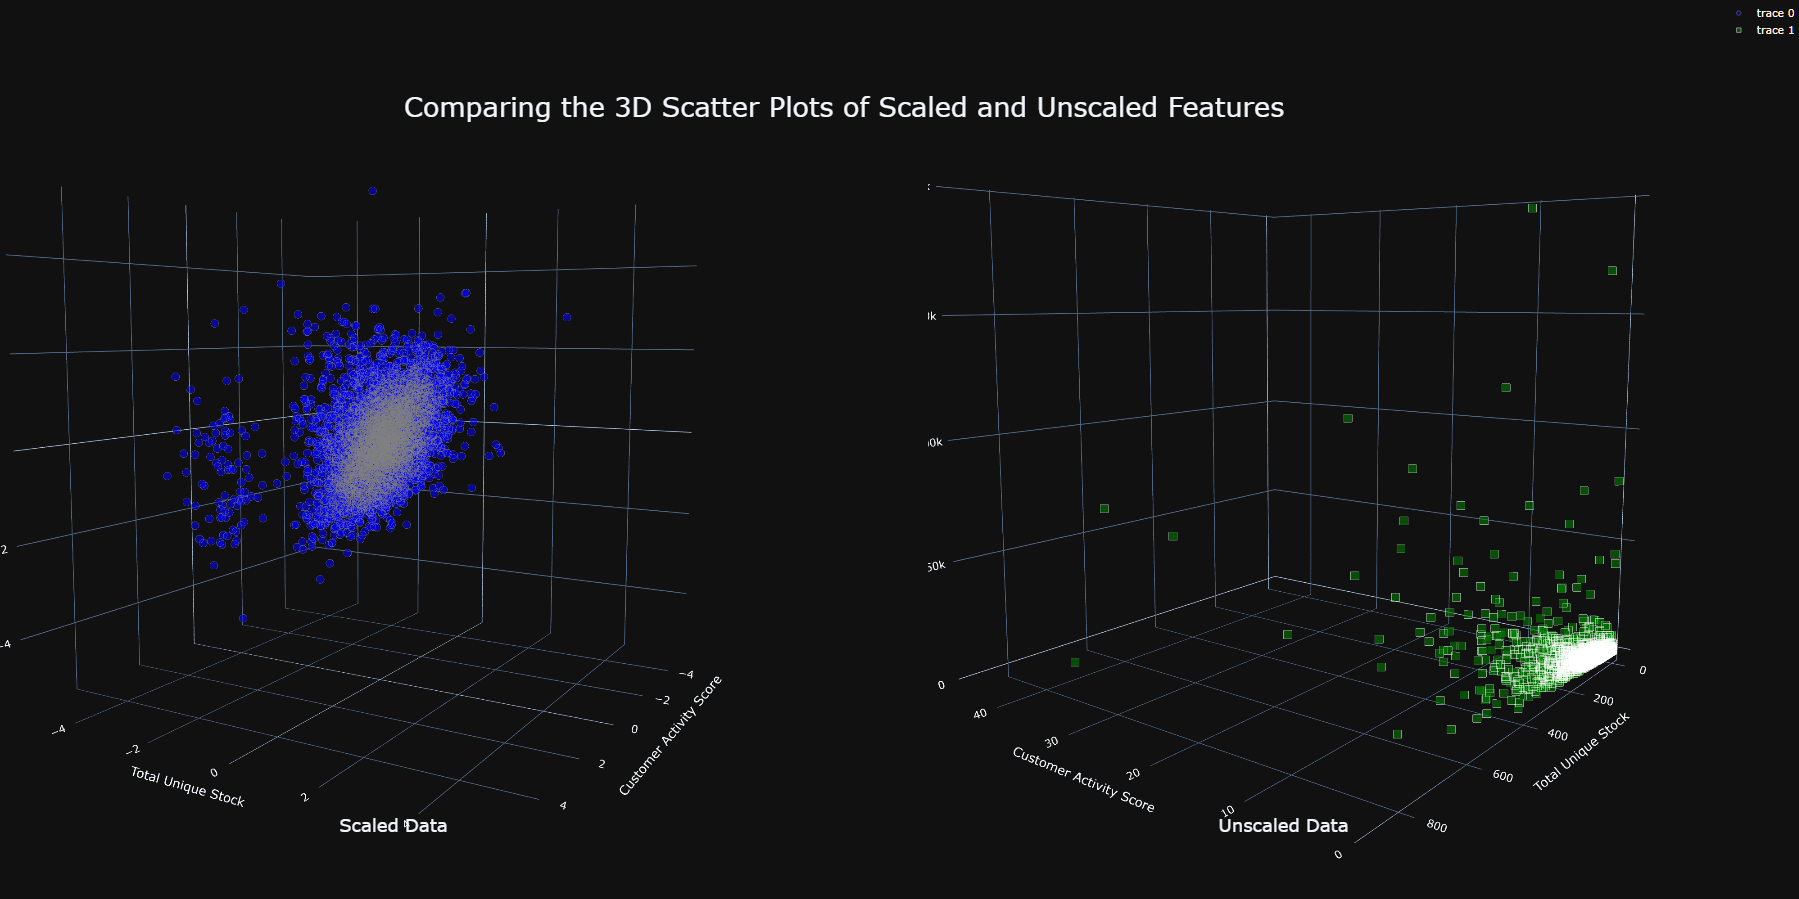

In [ ]:
#Create some 3D scatterplots to visualize how scaling might affect our clustering attempt
fig = subplots.make_subplots(rows=1, cols=2, specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]])


fig.add_trace(
    go.Scatter3d(
        x=np.array(customer_stats_scaled['customer_activity_score']),
        y=np.array(customer_stats_scaled['total_unique_stock']),
        z=np.array(customer_stats_scaled['total_purchases']),
        mode='markers',
        marker=dict(color='blue', symbol='circle', size=5, opacity=0.75,
                    line=dict(color='gray',width=1)),
        line=dict(color='white',width=2)
    ),
    row=1, col=1
)


fig.add_trace(
    go.Scatter3d(
        x=np.array(customer_stats_no_outliers['customer_activity_score']),
        y=np.array(customer_stats_no_outliers['total_unique_stock']),
        z=np.array(customer_stats_no_outliers['total_purchases']),
        mode='markers',
        marker=dict(color='green', symbol='square', size=5, opacity=0.75,
                    line=dict(color='white',width=1)),
    ),
    row=1, col=2
)

fig.update_layout( width=2000, height=1000, margin=dict(l=0, r=0, b=20, t=0), 
        annotations=[
            dict(text="Scaled Data",  x=0.20, y=.05, xref="paper", yref="paper", font=dict(size=20), showarrow=False),
            dict(text="Unscaled Data",  x=0.8, y=.05, xref="paper", yref="paper", font=dict(size=20), showarrow=False),
            dict(text="Comparing the 3D Scatter Plots of Scaled and Unscaled Features",  x=0.5, y=.9, xref="paper", yref="paper", font=dict(size=30), showarrow=False)],
        scene=dict(
            xaxis_title='Customer Activity Score',
            yaxis_title='Total Unique Stock',
            zaxis_title='Total Purchases'
    ),
        scene2=dict(
            xaxis_title='Customer Activity Score',
            yaxis_title='Total Unique Stock',
            zaxis_title='Total Purchases'
    ),
    )

#fig.show()
#fig.write_html("plot.html")
Image('customer_seg_scaled_unscaled_clusters.png')
# Update layout

In [ ]:
#Looking at the differences in the two 3D scatterplots, we definitely see more dispersion and better variance/dispersion with regards to the center in the scaled graph vs the unscaled graph, which should lead itself to more effective clustering attempts.

In [ ]:
from sklearn.mixture import GaussianMixture 
import optuna

#Initialize a seed and X variable
seed = np.random.RandomState(seed=42)
X = customer_stats_scaled[['customer_activity_score', 'total_unique_stock', 'total_purchases']]


In [ ]:
import optuna
from optuna.trial import Trial
#We will be using a GaussianMixture Model that will incorporate the meeans produced by a base Gaussian Mixture, in order to initialize the starting points for our clusters which will enable our model to converge faster.

def initial_means(n_components, method, seed, tol):
        model = GaussianMixture(
                n_components=n_components, init_params=method, tol=tol, max_iter=0, random_state=seed
            )
        model.fit(X)
        return model.means_

#All other parameters that will determine how clusters will be formed are tuned through Optuna, an optimization library that will help generate parameter values that produces the best fit. This is determined through the model's BIC score, lower numbers indicate a better fit.
# We will be tuning the number of components (essentially determining the number of clusters), the initialization method for our starting means, the tolerance threshold, and covariance type which will dictate how our clusters are formed and pick the set of parameters that produces the lowest BIC.


def objective(trial):
    method = trial.suggest_categorical('method', ["kmeans", "random_from_data", "k-means++", "random"])
    n_components = trial.suggest_int('n_components', 4,6)
    covariance_type = trial.suggest_categorical('covariance_type', ["spherical", "tied", "diag", "full"])
    tol = trial.suggest_float('tol', 5e-10, 1e-3, step=1e-10)
    #print(method, n_components, covariance_type)
    means = initial_means(n_components, method, seed, tol)

    model = GaussianMixture(
            n_components=n_components, means_init=means, covariance_type=covariance_type, tol=tol, max_iter=2000, random_state=seed, verbose=0
        )
    model.fit(X)
    
    score = model.bic(X)
    return score

samplertpe = optuna.samplers.TPESampler( n_startup_trials=10,  n_ei_candidates=15, multivariate=True, group=False)
study = optuna.create_study(directions=['minimize'], sampler=samplertpe)
study.optimize(objective, n_trials=250, n_jobs=1)
print(study.best_params)

c:\Users\eckz9\anaconda3\envs\NEWMLPROJECT\lib\site-packages\optuna\_experimental.py:31: ExperimentalWarning:

Argument ``multivariate`` is an experimental feature. The interface can change in the future.

[I 2024-11-18 15:11:39,463] A new study created in memory with name: no-name-b2818560-3575-4268-ae22-0fcc4ce22234
[I 2024-11-18 15:11:39,546] Trial 0 finished with value: 32014.012525159946 and parameters: {'method': 'random', 'n_components': 6, 'covariance_type': 'spherical', 'tol': 0.00016988890000000002}. Best is trial 0 with value: 32014.012525159946.
[I 2024-11-18 15:11:39,660] Trial 1 finished with value: 30093.833687682552 and parameters: {'method': 'kmeans', 'n_components': 4, 'covariance_type': 'full', 'tol': 0.0008303177}. Best is trial 1 with value: 30093.833687682552.
[I 2024-11-18 15:11:39,792] Trial 2 finished with value: 31330.978679432752 and parameters: {'method': 'random_from_data', 'n_components': 6, 'covariance_type': 'tied', 'tol': 0.0001495709}. Best is trial 1 

{'method': 'k-means++', 'n_components': 6, 'covariance_type': 'full', 'tol': 1.1434000000000001e-06}


In [ ]:
#Use the parameters determined by our Optuna run to create a GaussianMixture model 
n = 6
m = 'k-means++'
c = 'full'
tol = 2.6042e-05
#Note: Numbers above were generated from a previous run - not the one depicted in the output of the previous cell

means = initial_means(n, m, seed, tol=tol)

model = GaussianMixture(
        n_components=n, means_init=means, covariance_type=c, tol=tol, max_iter=10000, random_state=seed, verbose=0, warm_start=True
    )

model.fit(X)
model.bic(X)

means
#Displaying the means and saving the values as this essentially dictates how the clusters will be formed, and can be used to create reproducable clustering attempts

array([[-0.17910169,  0.21620388, -0.16714437],
       [ 1.02300326,  0.83200627,  1.05748728],
       [-1.1669186 , -5.19933758, -1.12914789],
       [-2.13168157, -0.19825847, -1.10891213],
       [-0.01881964, -1.61133325, -2.09181077],
       [-0.85167519, -0.61654097, -0.25417162]])

In [ ]:
#Continue to refit the model for as many iterations needed until no further improvements on BIC occurs
for i in range(0,1000):
    model.fit(X)
        
    score = model.bic(X)
    score
    if i % 100 == 0:
        print(score)

29030.6884825393
29030.688482539266
29030.688482539255
29030.68848253925
29030.688482539255
29030.68848253925
29030.688482539255
29030.688482539255
29030.688482539255
29030.688482539255


In [ ]:
#Create a copy of our scaled X and add the label outputs generated by our model
X_copy = X.copy()
X_copy['Label'] = model.predict(X)
X_copy['Label'] = X_copy['Label'].astype(str)

#Finally we add the label column back to our unscaled dataframe so that we can generate some meaningful and interpretable analysis
label_dict = X_copy['Label'].to_dict()
customer_stats_no_outliers = customer_stats_no_outliers.reset_index()
customer_stats_no_outliers['Label'] = customer_stats_no_outliers['index'].map(label_dict)
customer_stats_no_outliers = customer_stats_no_outliers.set_index('index')


,index,num_orders,num_order_days,days_since_last,order_freq,ave_stock_per_order,ave_qty,ave_purchased,total_unique_stock,total_qty,total_purchases,customer_activity_score,Label
0,16583,1.00,1.00,373.00,0.27,14.00,111.00,233.45,14.00,111.00,233.45,0.01,3
1,15165,1.00,1.00,373.00,0.27,27.00,160.00,487.75,27.00,160.00,487.75,0.01,3
2,14729,1.00,1.00,373.00,0.27,69.00,197.00,313.49,69.00,197.00,313.49,0.01,3
3,14142,1.00,1.00,373.00,0.27,22.00,313.00,311.81,22.00,313.00,311.81,0.01,3
4,18074,1.00,1.00,373.00,0.27,13.00,190.00,489.60,13.00,190.00,489.60,0.01,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4323,13777,33.00,24.00,0.00,6.43,5.97,390.82,787.19,36.00,12897.00,25977.16,16.45,1
4324,17490,7.00,6.00,0.00,3.41,10.86,162.00,298.90,63.00,1134.00,2092.32,3.90,1
4325,12985,2.00,2.00,0.00,7.14,38.00,766.50,619.69,73.00,1533.00,1239.38,1.48,1
4326,16446,2.00,2.00,0.00,0.98,1.50,40498.50,84236.25,3.00,80997.00,168472.50,1.48,1


In [22]:
#Here we select the columns related to the features we used for clustering. and display the summary statustics for the entire df, and every dataframe for each label in order to see if our model was able to create well defined and insightful segmentation between customer groups
X_unscaled = customer_stats_no_outliers[['num_orders', 'days_since_last', 'customer_activity_score', 'total_unique_stock', 'total_purchases', 'label']]
X_unscaled['label'] = X_unscaled['label'].astype(str)

X0 = X_unscaled[X_unscaled['label'] == '0']
X1 = X_unscaled[X_unscaled['label'] == '1']
X2 = X_unscaled[X_unscaled['label'] == '2']
X3 = X_unscaled[X_unscaled['label'] == '3']
X4 = X_unscaled[X_unscaled['label'] == '4']
X5 = X_unscaled[X_unscaled['label'] == '5']

print('Left: Main DF Statistics/Right: Cluster 1 Statistics')
display_side_by_side(X_unscaled.describe(), X1.describe())
print('-----------------------------------------------------')
print('Left: Cluster 0 Statistics/Right: Cluster 5 Statistics')
display_side_by_side(X0.describe(), X5.describe())

Left: Main DF Statistics/Right: Cluster 1 Statistics


,num_orders,days_since_last,customer_activity_score,total_unique_stock,total_purchases
count,4328.00,4328.00,4328.00,4328.00,4328.00
mean,4.10,92.35,0.63,59.93,1839.06
std,5.93,100.19,1.86,72.15,6402.96
min,1.00,0.00,0.01,1.00,3.75
25%,1.00,17.00,0.04,16.00,305.28
50%,2.00,50.50,0.12,35.00,665.98
75%,5.00,142.25,0.44,77.00,1626.26
max,97.00,373.00,44.46,884.00,194550.79
,num_orders,days_since_last,customer_activity_score,total_unique_stock,total_purchases
count,1639.00,1639.00,1639.00,1639.00,1639.00


-----------------------------------------------------
Left: Cluster 0 Statistics/Right: Cluster 5 Statistics


,num_orders,days_since_last,customer_activity_score,total_unique_stock,total_purchases
count,1539.00,1539.00,1539.00,1539.00,1539.00
mean,2.86,101.09,0.26,46.05,976.94
std,2.25,95.99,0.48,34.79,926.46
min,1.00,0.00,0.01,3.00,102.00
25%,1.00,28.00,0.03,21.00,365.45
50%,2.00,64.00,0.09,35.00,659.46
75%,4.00,161.00,0.26,61.00,1212.91
max,17.00,372.00,6.90,269.00,10815.43
,num_orders,days_since_last,customer_activity_score,total_unique_stock,total_purchases
count,990.00,990.00,990.00,990.00,990.00


These first three clusters are what we can consider to be our core customer base split up into 3 different segments all of different qualities. 

-- Cluster 1 is the biggest cluster out of the 6, and more importantly outperforms all others, including the averages produced by the entire dataframe. This is an important segment of customers that need to be focused on and further analyze as on average, they have higher total purchases, purchase a wider variety of products, have placed an order recently, and have placed more orders overall as a group. This group is essentially the lifeblood of the business and analyzing the trends and habits of this customer segment is vital for the future of the business

-- Cluster 0 while comparable to cluster 1 in size, does fall behind in all the other key columns. Still, the averages of this group are close to the overall averages of the entire customer base, which makes this population a good representative of the whole, and analyzing the differences of this Cluster with both Cluster 1 and the entire customer population will help in gaining insight of what helps in maintaining a healtlhy base of customers with regards to the latter, and possibly help identify what drives further growth with regards to the former.

-- Cluster 5 Is the lowest performing major cluster, and could represent customers that have either stopped doing business, are customers located outside of the United Kingdom or are new customers that are still testing things out. Analyzing this group could be important to understanding churn and developing an e business environment that is conducive to customer retention, or if they are located out of the country - how more international customers can be reached.   

In [ ]:

c1_percent = X1["total_purchases"].sum()/X_unscaled["total_purchases"].sum()*100
X1_no_outliers = X1[X1['total_purchases'] < stats_df.loc['99%', 'total_purchases']]
c1_percent2 = X1_no_outliers['total_purchases'].sum()/X_unscaled['total_purchases'].sum()*100
f'Cluster 1 makes up {c1_percent:.2f}% of all total sales overall, and after filtering all accounts above the 99th percentile (representing possible outliers), still represents {c1_percent2:.2f}% of all sales' 

'Cluster 1 makes up 75.60% of all total sales overall, and after filtering all accounts above the 99th percentile (representing possible outliers), still represents 51.76% of all sales'

In [61]:
print('Left: Main DF Statistics/Right: Cluster 3 Statistics')
display_side_by_side(X_unscaled.describe(), X3.describe())
print('-----------------------------------------------------')
print('Left: Cluster 2 Statistics/Right: Cluster 4 Statistics')
display_side_by_side(X2.describe(), X4.describe())

Left: Main DF Statistics/Right: Cluster 3 Statistics


,num_orders,days_since_last,customer_activity_score,total_unique_stock,total_purchases
count,4328.00,4328.00,4328.00,4328.00,4328.00
mean,4.10,92.35,0.63,59.93,1839.06
std,5.93,100.19,1.86,72.15,6402.96
min,1.00,0.00,0.01,1.00,3.75
25%,1.00,17.00,0.04,16.00,305.28
50%,2.00,50.50,0.12,35.00,665.98
75%,5.00,142.25,0.44,77.00,1626.26
max,97.00,373.00,44.46,884.00,194550.79
,num_orders,days_since_last,customer_activity_score,total_unique_stock,total_purchases
count,14.00,14.00,14.00,14.00,14.00


-----------------------------------------------------
Left: Cluster 2 Statistics/Right: Cluster 4 Statistics


,num_orders,days_since_last,customer_activity_score,total_unique_stock,total_purchases
count,94.00,94.00,94.00,94.00,94.00
mean,1.37,188.54,0.08,1.00,1622.74
std,0.83,116.41,0.17,0.00,8895.01
min,1.00,2.00,0.01,1.00,3.75
25%,1.00,89.25,0.01,1.00,71.40
50%,1.00,191.50,0.02,1.00,170.10
75%,1.00,293.00,0.05,1.00,440.00
max,5.00,373.00,1.28,1.00,77183.60
,num_orders,days_since_last,customer_activity_score,total_unique_stock,total_purchases
count,52.00,52.00,52.00,52.00,52.00


The last 3 clusters are all fringe clusters representing different specific customer segments - with Cluster 2 being the group with the lowest unique stock purchases (actually only a single individual stock), Cluster 3 comprising of single order counts and longest days since last order, while Cluster 4 representing an interesting segment that purchases a specific combination of items in varying degrees of frequency and dollar values. As a whole these clusters constitute a small segment of the business, but some insights might still be gained by identifying what individual or group of items bring certain customers (similar to those in Cluster 4 and 2) to the online storefront, as continuing to provide the same or similar products could help with customer retention.

In [64]:
c234_percent = (X3["total_purchases"].sum()+X2["total_purchases"].sum()+X4["total_purchases"].sum()) /X_unscaled["total_purchases"].sum()*100
c234_percent_order = (X3["num_orders"].sum()+X2["num_orders"].sum()+X4["num_orders"].sum()) /X_unscaled["num_orders"].sum()*100

f'Cluster 2,3 and 4 combined make up {c234_percent:.2f}% of all total sales overall, and {c234_percent_order:.2f}% of all business volume in terms of orders'

'Cluster 2,3 and 4 combined make up 2.28% of all total sales overall, and 1.35% of all business volume in terms of orders'

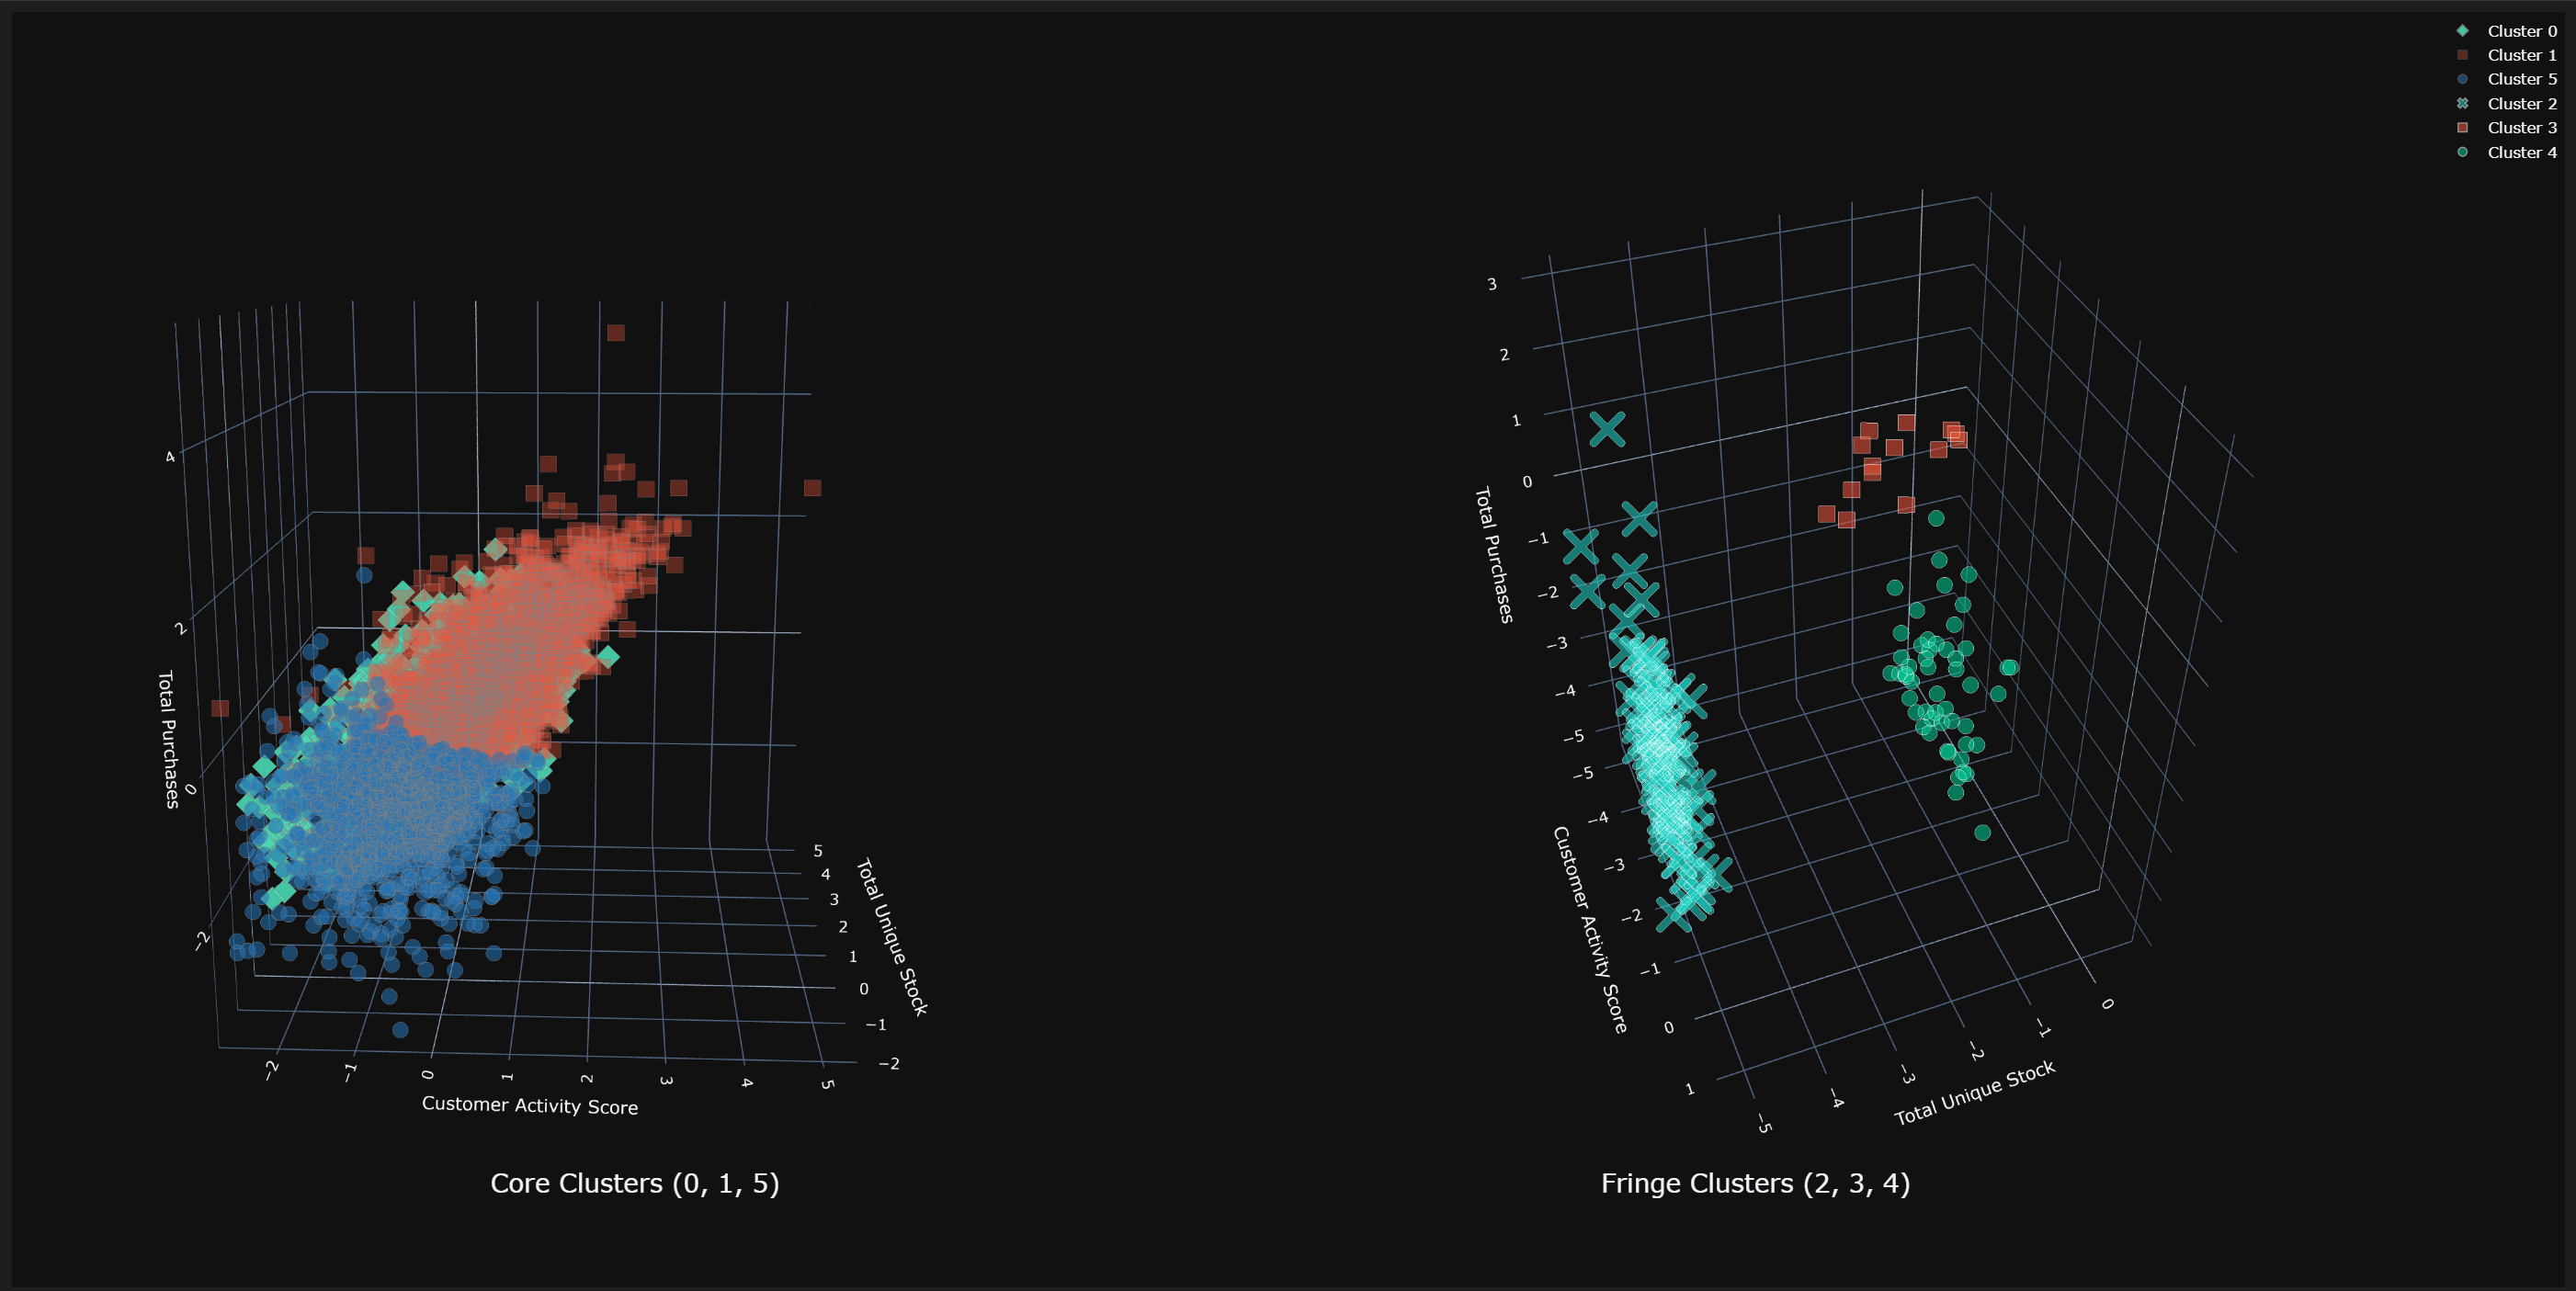

In [ ]:
#The code below creates a 3D Scatterplot that visualizes the difference between the 3 major clusters and the 3 minor clusters.

X_copy1 = X_copy[X_copy['Label'].isin(['0','1','5'])]
X_copy1['color'] = X_copy1['Label'].astype(int)

X_copy2 = X_copy[X_copy['Label'].isin(['2','3','4'])]
X_copy2['color'] = X_copy2['Label'].astype(int)
fig = subplots.make_subplots(rows=1, cols=2, specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}]])

# Define a color map for the clusters
color_map = { 0:'#4ad9b4', 1:'#ef553b',  5:'#2474b7', 4:'#00cc96', 2:'#1dd6c9', 3:'#ef553b',} 
symbol_map = {0: 'diamond', 1:'square',  5:'circle',  4: 'circle', 2:'x', 3:'square', } 

# Create a trace for each unique cluster label in the first plot
for label in set(X_copy1['color']):
    mask = np.array(X_copy1['color']) == label
    fig.add_trace(
        go.Scatter3d(
            x=np.array(X_copy1['customer_activity_score'])[mask],
            y=np.array(X_copy1['total_unique_stock'])[mask],
            z=np.array(X_copy1['total_purchases'])[mask],
            mode='markers',
            marker=dict(color=color_map[label], symbol=symbol_map[label], size=7, opacity=0.55,
                        line=dict(color='gray',width=1)),
            line=dict(color='white',width=2),
            name=f'Cluster {label}'
        ),
        row=1, col=1
    )

# Create a trace for each unique cluster label in the second plot
for label in set(X_copy2['color']):
    mask = np.array(X_copy2['color']) == label
    fig.add_trace(
        go.Scatter3d(
            x=np.array(X_copy2['customer_activity_score'])[mask],
            y=np.array(X_copy2['total_unique_stock'])[mask],
            z=np.array(X_copy2['total_purchases'])[mask],
            mode='markers',
            marker=dict(color=color_map[label], symbol=symbol_map[label], size=7, opacity=0.55,
                        line=dict(color='white',width=1)),
            name=f'Cluster {label}'
        ),
        row=1, col=2
    )


# Update layout

fig.update_layout( width=2000, height=1000, margin=dict(l=0, r=0, b=20, t=0), 
        annotations=[
            dict(text="Core Clusters (0, 1, 5)",  x=0.20, y=.05, xref="paper", yref="paper", font=dict(size=20), showarrow=False),
            dict(text="Fringe Clusters (2, 3, 4)",  x=0.8, y=.05, xref="paper", yref="paper", font=dict(size=20), showarrow=False)],
        scene=dict(
            xaxis_title='Customer Activity Score',
            yaxis_title='Total Unique Stock',
            zaxis_title='Total Purchases'
    ),
        scene2=dict(
            xaxis_title='Customer Activity Score',
            yaxis_title='Total Unique Stock',
            zaxis_title='Total Purchases'
    ),
    )

fig.update_traces(marker=dict(opacity=0.35), selector=dict(name='Cluster 1'))
fig.update_traces(marker=dict(opacity=.9), selector=dict(name='Cluster 0'))

# Show the figure
#fig.show()
Image('clust3.png')